In [63]:
import os
import datetime
import requests
import zipfile
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
%matplotlib inline

# 0. Get Data

    def get_data(data_url):
        with requests.get(data_url) as r:

            with zipfile.ZipFile(io.BytesIO(r.content)) as z:
                z.extractall()

    data_url = "http://quantquote.com/files/quantquote_daily_sp500_83986.zip"

    get_data(data_url=data_url)

In [3]:
data_dir = os.path.join("quantquote_daily_sp500_83986", "daily")

In [4]:
len(os.listdir(data_dir))

500

In [5]:
def get_csv_path(csv_name, stock_csv_folder=data_dir):
    return os.path.join(stock_csv_folder, csv_name)

In [6]:
cols = ['date', 'time', 'open', 'high', 'low_price', 'close', 'volume']

In [7]:
def get_df(csv_name, cols=cols):
    df = pd.read_csv(get_csv_path(csv_name),
                     names=cols,
                     usecols=list(filter(lambda c: c!= "time", cols)))
    
    df.date = pd.to_datetime(df.date.astype(str), infer_datetime_format=True)

    return df.set_index("date", drop=False)

In [8]:
aapl_df = get_df("table_aapl.csv")

In [9]:
aapl_df.head()

,date,open,high,low_price,close,volume
date,,,,,,
1998-01-02,1998-01-02,3.31397,3.95098,3.28236,3.95098,24947201.10
1998-01-05,1998-01-05,4.01177,4.02635,3.69325,3.89020,22344145.08
1998-01-06,1998-01-06,3.87561,4.98432,3.58628,4.60502,63150252.55
1998-01-07,1998-01-07,4.57341,4.68040,4.20871,4.24032,36978255.52
1998-01-08,1998-01-08,4.24032,4.52965,4.11875,4.39107,27687622.95


# 1. Exploratory Analysis

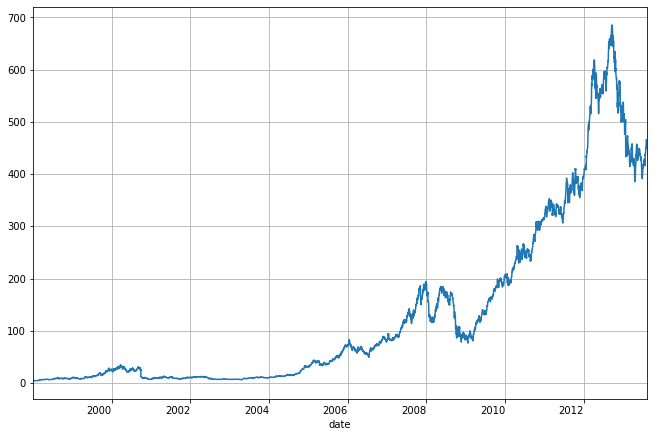

In [10]:
ax = aapl_df.close.plot(figsize=(11, 8), rot=0)
g = ax.grid(True)
t = ax.title.set_text("AAPL: closing price, over time")

**Unit Root**

A real treatment of this concept is outside of our scope today, but you can read more about it [here](https://en.wikipedia.org/wiki/Unit_root) or [here](https://faculty.chicagobooth.edu/ruey.tsay/teaching/uts/lec11-08.pdf). For now, I'll go ahead and collquially summarize the _unit root_ concept with the following ...

Many statistical models require the assumption of certain distributional properties in the data. A key assumption is that of [*stationarity*](https://en.wikipedia.org/wiki/Stationary_process), which (among other things) means that the _mean_ and _variance_ of the data do not change over time.

If you are looking at the original and not relative-change values of your data, the data's distributional parameters, i.e. _mean_ and _variance_ are likely going to change, depending on how you slice into the data.

On the other hand, if your data follows a stationary process, the way in which it _changes_ should itself not be changing. Maybe a way to think of this is: we want to model the process, or the changes in the data, and not the data's initial conditions. If you don't make take this into account, you can get some very warped results.

Thus, something you'll often see is a change from the original values to the proportionate changes, with respect to the previous period(s). In finance, that means looking at _returns_ as opposed to _prices_.

In [11]:
aapl_df["return_daily"] = aapl_df.close.pct_change()

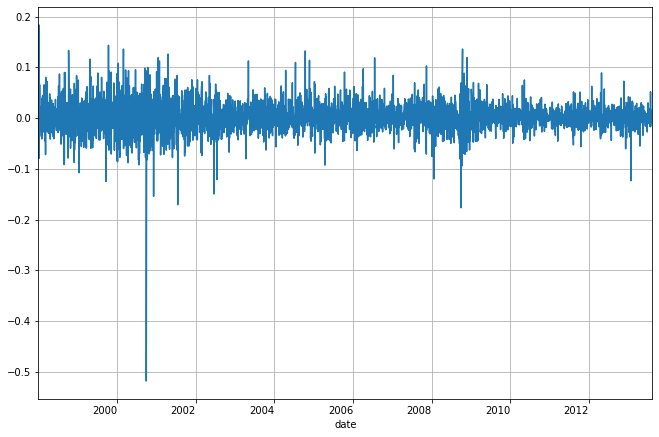

In [12]:
ax = aapl_df.return_daily.plot(figsize=(11, 8), rot=0)
g = ax.grid(True)

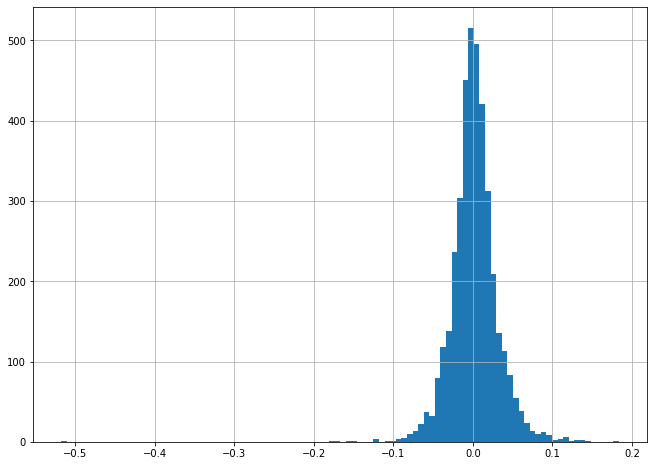

In [13]:
ax = aapl_df.return_daily.hist(bins=100, figsize=(11, 8))
g = ax.grid(True)

In [14]:
aapl_df.return_daily.rename("t"
                   ).to_frame(
                   ).join(
                        aapl_df.return_daily.shift(1).rename("t-1")
                   ).corr()

,t,t-1
t,1.000000,-0.034992
t-1,-0.034992,1.000000


### --

### Problem

- get _autocorrelation_ going back through 30 lags
- plot the results - make sure to label your plot

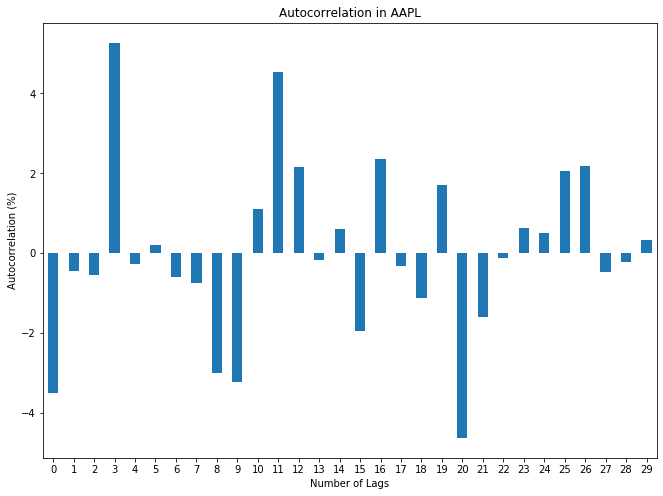

In [15]:
aapl_autocorr = pd.Series([aapl_df.return_daily.rename("t"
                                               ).to_frame(
                                               ).join(
                                                    aapl_df.return_daily.shift(i).rename("t-1")
                                               ).corr().iloc[1, 0]
                                for i in range(1, 31)],
                                name="Autocorrelation in AAPL"
                                     )

ax = aapl_autocorr.multiply(100).plot.bar(figsize=(11, 8), rot=0)

t = ax.set_title(aapl_autocorr.name)
xlab = ax.set_xlabel("Number of Lags")
ylab = ax.set_ylabel("Autocorrelation (%)")

### --

### Monthly Returns

In [16]:
aapl_df["year"] = aapl_df.date.dt.year

In [17]:
aapl_df["month"] = aapl_df.date.dt.month

In [18]:
aapl_df["return_daily_gross"] = aapl_df.return_daily + 1

In [19]:
aapl_df.head()

,date,open,high,low_price,close,volume,return_daily,year,month,return_daily_gross
date,,,,,,,,,,
1998-01-02,1998-01-02,3.31397,3.95098,3.28236,3.95098,24947201.10,NaN,1998,1,NaN
1998-01-05,1998-01-05,4.01177,4.02635,3.69325,3.89020,22344145.08,-0.015384,1998,1,0.984616
1998-01-06,1998-01-06,3.87561,4.98432,3.58628,4.60502,63150252.55,0.183749,1998,1,1.183749
1998-01-07,1998-01-07,4.57341,4.68040,4.20871,4.24032,36978255.52,-0.079196,1998,1,0.920804
1998-01-08,1998-01-08,4.24032,4.52965,4.11875,4.39107,27687622.95,0.035552,1998,1,1.035552


In [20]:
aapl_monthly = aapl_df.groupby(["year", "month"]).return_daily_gross.prod()

In [25]:
aapl_monthly.shape

(188,)

In [22]:
aapl_monthly = aapl_monthly.rename("return_t")

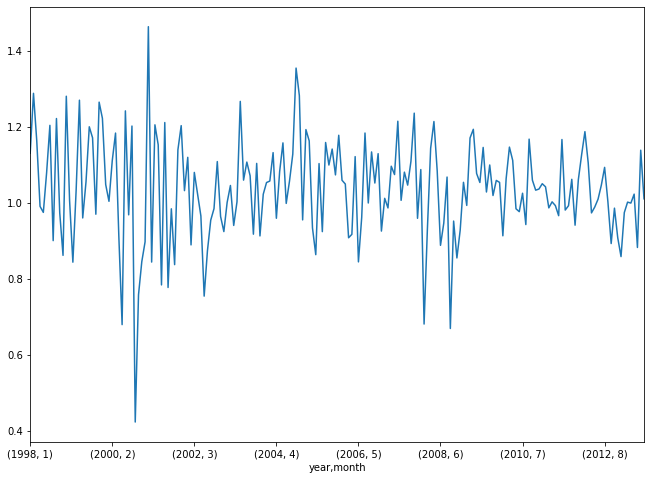

In [23]:
ax = aapl_monthly.plot(figsize=(11, 8))
t = ax.set_title("AAPL: monthly gross returns")

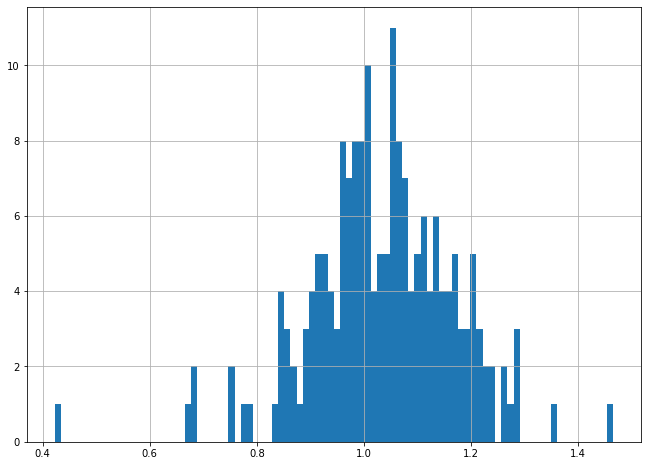

In [26]:
ax = aapl_monthly.hist(bins=90, figsize=(11, 8))
t = ax.title.set_text("AAPL: histogram of monthly, gross returns")

In [28]:
aapl_monthly = aapl_monthly.to_frame()

In [29]:
aapl_monthly["return_t_minus_1"] = aapl_monthly.return_t.shift(1)

In [30]:
aapl_monthly.corr()

,return_t,return_t_minus_1
return_t,1.000000,0.028486
return_t_minus_1,0.028486,1.000000


In [43]:
aapl_df = aapl_df.join(
                    aapl_df.return_daily_gross.rolling(21
                                             ).apply(np.prod, raw=True
                                             ).rename("return_daily_rolling_21")
                    -1 )

In [47]:
aapl_df.return_daily.to_frame().join(aapl_df.return_daily_rolling_21.shift(1)).corr()

,return_daily,return_daily_rolling_21
return_daily,1.000000,-0.005484
return_daily_rolling_21,-0.005484,1.000000


In [59]:
aapl_df = aapl_df.join(
                    aapl_df.return_daily_gross.rolling(63
                                             ).apply(np.prod, raw=True
                                             ).rename("return_daily_rolling_63")
                    -1 )

In [60]:
aapl_df.return_daily.to_frame().join(aapl_df.return_daily_rolling_63.shift(1)).corr()

,return_daily,return_daily_rolling_63
return_daily,1.000000,0.015047
return_daily_rolling_63,0.015047,1.000000


In [61]:
aapl_df = aapl_df.join(
                    aapl_df.return_daily_gross.rolling(63
                                             ).std(
                                             ).rename("return_vol_rolling_63")
                    -1 )

In [62]:
aapl_df.return_daily.to_frame().join(aapl_df.return_vol_rolling_63.shift(1)).corr()

,return_daily,return_vol_rolling_63
return_daily,1.000000,-0.032769
return_vol_rolling_63,-0.032769,1.000000


### --

### Problem
- engineer some more features to use and evaluate their performance
- could look at cumulative, rolling returns; could pull in another stock's performance; etc.

### --

# 2. First Pass at Predictive Modeling

### Feature Engineering

In [67]:
def get_shifted(srs, shift_start, shift_end):
    """
    Returns a df, with each column corresponding to `srs` being shifted,
    starting with `shift_start` number of shifts and going through
    `shift_end`.
    """
    return pd.concat([
                        srs.shift(i).rename(f"{srs.name}_shifted_{i}")
                        for i in range(shift_start, shift_end + 1)
            ], axis=1)

In [69]:
aapl_features = get_shifted(aapl_df.return_daily, 1, 21)

In [71]:
aapl_features.shape

(3926, 21)

In [72]:
aapl_features = aapl_features.join(
                    aapl_df[[
                        "return_daily_rolling_21",
                        "return_daily_rolling_63",
                        "return_vol_rolling_63"
                    ]])

In [73]:
aapl_features.shape

(3926, 24)

In [75]:
aapl_features = aapl_features.join(aapl_df.month)

### Train / Test

In [76]:
train = aapl_df.loc[
                (aapl_df.year == 2009)
                &
                (aapl_df.month < 10)
                    ].index

In [77]:
test = aapl_df.loc[
                (aapl_df.year == 2009)
                &
                (aapl_df.month >= 10)
                    ].index

In [86]:
X_train = aapl_features.loc[train]

In [79]:
X_test = aapl_features.loc[test]

In [81]:
y_train = aapl_df.loc[train, "return_daily"]

In [100]:
y_train.shape

(188,)

In [82]:
y_test = aapl_df.loc[test, "return_daily"]

In [101]:
y_test.shape

(64,)

In [111]:
aapl_features.columns.tolist()

['return_daily_shifted_1',
 'return_daily_shifted_2',
 'return_daily_shifted_3',
 'return_daily_shifted_4',
 'return_daily_shifted_5',
 'return_daily_shifted_6',
 'return_daily_shifted_7',
 'return_daily_shifted_8',
 'return_daily_shifted_9',
 'return_daily_shifted_10',
 'return_daily_shifted_11',
 'return_daily_shifted_12',
 'return_daily_shifted_13',
 'return_daily_shifted_14',
 'return_daily_shifted_15',
 'return_daily_shifted_16',
 'return_daily_shifted_17',
 'return_daily_shifted_18',
 'return_daily_shifted_19',
 'return_daily_shifted_20',
 'return_daily_shifted_21',
 'return_daily_rolling_21',
 'return_daily_rolling_63',
 'return_vol_rolling_63',
 'month']

### Additional Prep

In [88]:
X_train.dtypes.value_counts()

float64    24
int64       1
dtype: int64

In [89]:
scaler = StandardScaler()

In [92]:
float_cols = X_train.select_dtypes(include=float).columns

In [93]:
X_train.loc[:, float_cols] = scaler.fit_transform(X_train.loc[:, float_cols])

In [94]:
X_test.loc[:, float_cols] = scaler.fit_transform(X_test.loc[:, float_cols])

### `LinearRegression` 

In [95]:
linreg = LinearRegression()

In [96]:
linreg = linreg.fit(X_train, y_train)

In [98]:
linreg.score(X_train, y_train)

0.9480997046474106

In [99]:
linreg.score(X_test, y_test)

-1.1086292410723533

### `Ridge` 

In [107]:
ridge = Ridge(alpha=10)

In [108]:
ridge = ridge.fit(X_train, y_train)

In [109]:
ridge.score(X_train, y_train)

0.5620129221780635

In [110]:
ridge.score(X_test, y_test)

0.4570863648300462

# 3. Walk-Forward Validation

Just as in cross-sectional modeling, where *cross validation* is used, we want unbiased estimations of model performance. In time-series modeling, however, we need to be very careful not to leak data, which can be easy to do when there is a strict chronology. So, we run train / test splits over different parts of the data, where train _always_ comes before test.

Specifically:

- we run run a number of trials of this splitting on a validation part of the data
- this is where we make decisions around features to use, hyper-parameter tuning, etc.
- then, on a _later_ chunk of the data, we'll run some more trials, where we make no changes, and these are the numbers we report
- we can use 3, 5, 10, etc. trials in each of the validation and test sets, just like in classic CV
- and we use the mean (and maybe, standard deviation) across these trials for our decision making and results reporting


### --

### Problem

- write a program to perform walk-forward validation